## All the import

In [1]:
import numpy as np
import RNA
from random import randint
import matplotlib.pyplot as plt
import pdb
from math import  sqrt
import pandas as pd
import csv

## Load the data

In [8]:
'''
Generate a sequence : random succession of 'a' 'g' 'c' 'u' of size longueur
'''
def generate_rna(longueur):
    seq = ''
    for i in range(longueur):
        rand=randint(0,3)
        if rand == 0:
            seq = seq + 'a'
        elif rand == 1:
            seq = seq + 'g'
        elif rand == 2:
            seq = seq + 'c'
        else:
            seq = seq + 'u'
    return seq

In [9]:
'''
Return the prediction array :
if structure[i] is parenthese then prediction[i] = 1
if structure has more than 10 parentheses in interaction site locate between 85 and 85+longueur
then all the value of prediction array between the 85th and 85+longueur th would be set to 1
'''
def get_predictions(structure, longueur, sense = 0):
    length = len(structure)
    prediction = np.zeros(length)
    index = 0
    nbparent = 0
    
    if(sense != 0):
        structure = structure[::-1]

    for char in structure[:85]:
        if char == '(' or char == ')':
            prediction[index] = 1
            index+=1
    
    for char in structure[85:85+longueur]:
        if char == '(' or char == ')':
            prediction[index] = 1
            nbparent+=1
        if(nbparent == 10):
            ones = np.ones(longueur)
            for i in range(longueur):
                prediction[i+85] = ones[i]
            break
        index+=1
    
    index = 85 + longueur
    for char in structure[85+longueur:]:
        if char == '(' or char == ')':
            prediction[index] = 1
        index+=1
    
    return prediction

In [10]:
'''
Return the structures of the two sequence calculated by RNA Subopt
'''
def get_rna_subopt(s1, s2, longueur1, longueur2, direction = 1):
    print("RNA subopt")
    
    a = RNA.subopt(s1+'&'+s2, '', 10)
    
    struct1,struct2 = a.structure.split('&')
    
    prediction1 = get_predictions(struct1, longueur1, sense=direction)
    prediction2 = get_predictions(struct2, longueur2, sense=0)

    return prediction1, prediction2

In [11]:
'''
Return the structures of the two sequence calculated by RNA Duplex
'''
def get_rna_duplex(s1, s2, longueur1, longueur2, direction = 1):
    print("RNA duplex")
    
    a = RNA.duplexfold(s1,s2)
    struct1,struct2 = a.structure.split('&')
    
    i = int(a.i)
    j = int(a.j)
    len1 = len(s1)
    len2 = len(s2)
    
    #Adapt the structure because RNADuplex doesn't return a structure of the size of the sequence
    temp1 = '.'*(i-len(struct1))
    temp2 = '.'*(len1-i)
    struct1 = temp1+struct1+temp2
    
    temp1 = '.'*(j-1)
    temp2 = '.'*(len2-len(struct2)-j+1)
    struct2=temp1+struct2+temp2
    
    prediction1 = get_predictions(struct1, longueur1, sense=direction)
    prediction2 = get_predictions(struct2, longueur2, sense=0)
    
    return prediction1, prediction2

In [12]:
'''
Return the accuracy, precision, sensitivity, specificity
by comparing pred_y and labels, test_num is the length of the tab
'''
def calculate_performance(test_num, pred_y, labels):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for index in range(test_num):
        if labels[index] ==1:
            if labels[index] == pred_y[index]:
                tp = tp +1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn +1
            else:
                fp = fp + 1               
            
    acc = float(tp + tn)/test_num
    
    if (tp+fp) == 0:
        precision = 0
    else:
        precision = float(tp)/(tp+ fp)
    
    if (tp+fn) == 0:
        sensitivity = 0
    else:
        sensitivity = float(tp)/ (tp+fn)
    
    if (tn+fp) == 0:
        specificity = 0  
    else:
        specificity = float(tn)/(tn + fp)
    
    MCC = float(tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    print("Accuracy : ", acc)
    print("Precision : ", precision)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("MCC : ", MCC)
    return acc, precision, sensitivity, specificity, MCC

In [13]:
'''
Load the benchmark database and return it in several arrays
'''
def load_benchmark():
    print("Loading benchmark database")
    datatest = pd.read_csv("genomes/benchmark_interactionsv2.csv", sep = "\t", header=None)
    datatest = np.array(datatest)
    sequence1=[]
    sequence2=[]
    longueur1=[]
    longueur2=[]
    l = len(datatest)
    for i in range(l):
        #Treadtment and formatting of the database
        data = datatest[i][0].split(' ')
        data[0] = data[0].split('[')
        data[0][1] = data[0][1].split('\n')
        data[1] = data[1].split('\n')
        
        seq1=data[0][1][0]
        seq2=data[1][0]
        len1=int(data[2])
        len2=int(data[3])
        
        sequence1.append(seq1)
        sequence2.append(seq2)
        longueur1.append(len1)
        longueur2.append(len2)
    
    print("Benchmark database loaded")
    return sequence1, sequence2, longueur1, longueur2

In [14]:
'''
Calculate the performance of RNA Subopt and RNA Duplex and return them in two list,
one per tool. Each list contain 5 arrays : 
[ accuracy, precision, sensitivity, specificity, mcc ]
'''
def get_score_RNA():
    benchmark = load_benchmark()
    
    sequence1 = benchmark[0]
    sequence2 = benchmark[1]
    longueur1 = benchmark[2]
    longueur2 = benchmark[3]
    
    subopt_accuracy = []
    subopt_precision = []
    subopt_sensitivity = []
    subopt_specificity = []
    subopt_mcc = []
    
    duplex_accuracy = []
    duplex_precision = []
    duplex_sensitivity = []
    duplex_specificity = []
    duplex_mcc = []
    
    length = len(sequence1)
    
    print("Executing")
    
    for i in range(length):
        print("Index : ", i)
        seq1 = sequence1[i]
        seq2 = sequence2[i]
        #length of the interaction site in each sequence
        len1 = longueur1[i]
        len2 = longueur2[i]
        
        label1 = np.zeros(len(seq1))
        label2 = np.zeros(len(seq2))
        ones1 = np.ones(len1)
        ones2 = np.ones(len2)
        label1[85:85+len1] = ones1[:]
        label2[85:85+len2] = ones2[:]
        labels = np.concatenate((label1, label2), axis=0)
        
        prediction1, prediction2 = get_rna_subopt(seq1,seq2,len1,len2)
        predictions = np.concatenate((prediction1,prediction2) ,axis=0)
        
        performance = calculate_performance(len(seq1)+len(seq2), predictions, labels)
        
        #Append the performance value to the corresponding array
        subopt_accuracy.append(performance[0])
        subopt_precision.append(performance[1])
        subopt_sensitivity.append(performance[2])
        subopt_specificity.append(performance[3])
        subopt_mcc.append(performance[4])
        
        prediction1, prediction2 = get_rna_duplex(seq1,seq2,len1,len2)
        predictions = np.concatenate((prediction1,prediction2) ,axis=0)
        
        performance = calculate_performance(len(seq1)+len(seq2), predictions, labels)
        
        #Append the performance value to the corresponding array
        duplex_accuracy.append(performance[0])
        duplex_precision.append(performance[1])
        duplex_sensitivity.append(performance[2])
        duplex_specificity.append(performance[3])
        duplex_mcc.append(performance[4])
        
    #Bring together all the performance arrays
    subopt = []
    subopt.append(subopt_accuracy)
    subopt.append(subopt_precision)
    subopt.append(subopt_sensitivity)
    subopt.append(subopt_specificity)
    subopt.append(subopt_mcc)
    
    duplex = []
    duplex.append(duplex_accuracy)
    duplex.append(duplex_precision)
    duplex.append(duplex_sensitivity)
    duplex.append(duplex_specificity)
    duplex.append(duplex_mcc)
    
    return subopt, duplex

In [21]:
'''
Save the performance arrays in severals files, one file per array
tab is one of the tab retruned by the function get_score_RNA()
filename is the name of the tool like in the function above
'''
def save_performances(tab,filename):
    print("Saving the performances of " + filename)
    
    #Extract the different arrays
    accuracy = np.array(tab[0])
    precision = np.array(tab[1])
    sensitivity = np.array(tab[2])
    specificity = np.array(tab[3])
    mcc = np.array(tab[4])
    
    #Saving the arrays in different npy files
    np.save('benchmark_result/'+filename+'_accuracy.npy', accuracy)
    np.save('benchmark_result/'+filename+'_precision.npy', precision)
    np.save('benchmark_result/'+filename+'_sensitivity.npy', sensitivity)
    np.save('benchmark_result/'+filename+'_specificity.npy', specificity)
    np.save('benchmark_result/'+filename+'_mcc.npy', mcc)
    print("Performances of " + filename + " saved")

In [22]:
'''
This function load the arrays : accuracy, precision, sensitivity, specificity, mcc
of the tools on the benchmark database extracted from RISE
use 'subopt' for RNA Subopt
and 'duplex' for RNA Duplex
Plot the differents array with their average values on differents figures and
save the graph in several png file and return the different arrays
'''
def load_performances(filename):
    print("Loading the performances of " + filename)
    
    #Load all the performance arrays array from .npy files
    accuracy = np.load('benchmark_result/'+filename+'_accuracy.npy')
    precision = np.load('benchmark_result/'+filename+'_precision.npy')
    sensitivity = np.load('benchmark_result/'+filename+'_sensitivity.npy')
    specificity = np.load('benchmark_result/'+filename+'_specificity.npy')
    mcc = np.load('benchmark_result/'+filename+'_mcc.npy')
    length = len(accuracy)
    
    #Print the performance arrays with matplotlib and save the graph in png files
    x = np.linspace(1,length,length)
    
    #Print the accuracy and its average value
    fig1 = plt.figure(1)
    plt.clf()
    plt.title("Accuracy")
    p0=plt.plot(x,accuracy,label='Accuracy',marker='o')
    avg_accuracy = np.mean(accuracy)
    y = np.ones(length)
    y = np.dot(avg_accuracy,y)
    p1=plt.plot(x,y,marker='.')
    fig1.savefig('benchmark_result/'+filename+'_accuracy.png')
    
    #Print the precision and its average value
    fig2 = plt.figure(2)
    plt.clf()
    plt.title("Precision")
    p0=plt.plot(x,precision,label='Precision',marker='x')
    avg_precision = np.mean(precision)
    y = np.ones(length)
    y = np.dot(avg_precision,y)
    p1=plt.plot(x,y,marker='.')
    fig2.savefig('benchmark_result/'+filename+'_precision.png')
    
    #Print the sensitivity and its average value
    fig3 = plt.figure(3)
    plt.clf()
    plt.title("Sensitivity")
    p0=plt.plot(x,sensitivity, label='Sensitivity', marker='s')
    avg_sensitivity = np.mean(sensitivity)
    y = np.ones(length)
    y = np.dot(avg_sensitivity,y)
    p1 = plt.plot(x,y,marker='.')
    fig3.savefig('benchmark_result/'+filename+'_sensitivity.png')
    
    #Print the specificity and its average value
    fig4 = plt.figure(4)
    plt.clf()
    plt.title("Specificity")
    p0 = plt.plot(x,specificity, label='Specificity',marker='p')
    avg_specificity = np.mean(specificity)
    y = np.ones(length)
    y = np.dot(avg_specificity,y)
    p1 = plt.plot(x,y,marker='.')
    fig4.savefig('benchmark_result/'+filename+'_specificity.png')
    
    #Print the MCC and its average value
    fig5 = plt.figure(5)
    plt.clf()
    plt.title("MCC")
    p0 = plt.plot(x,mcc, label='MCC',marker='v')
    avg_mcc = np.mean(mcc)
    y = np.ones(length)
    y = np.dot(avg_mcc,y)
    p1 = plt.plot(x,y,marker='.')
    fig5.savefig('benchmark_result/'+filename+'_MCC.png')
    
    plt.show()
    
    print("Average accuracy : ", avg_accuracy)
    print("Average precision : ", avg_precision)
    print("Average sensitivity : ", avg_sensitivity)
    print("Average specificity : ", avg_specificity)
    print("Average MCC : ", avg_mcc)
    
    return accuracy, precision, sensitivity, specificity, mcc

In [23]:
'''
Plot all the performance arrays grouped in the list tab with their average value:
accuracy, precision, sensitivity, specificity, mcc
'''
def plot_performances(tab, longueur = 0):
    if longueur == 0:
        length = len(tab[0])
    else :
        if longueur < len(tab[0]):
            length = longueur
        else:
            length = len(tab[0])
    
    accuracy = np.zeros(length)
    precision = np.zeros(length)
    sensitivity = np.zeros(length)
    specificity = np.zeros(length)
    mcc = np.zeros(length)
    
    for i in range(length):
        accuracy[i]=tab[0][i]
        precision[i]=tab[1][i]
        sensitivity[i]=tab[2][i]
        specificity[i]=tab[3][i]
        mcc[i]=tab[4][i]
        
    x = np.linspace(1,length,length)

    #Print the accuracy and its average value
    fig1 = plt.figure(1)
    plt.clf()
    plt.title("Accuracy")
    p0=plt.plot(x,accuracy,label='Accuracy',marker='o')
    avg_accuracy = np.mean(accuracy)
    y = np.ones(length)
    y = np.dot(avg_accuracy,y)
    p1=plt.plot(x,y,marker='.')
    
    #Print the precision and its average value
    fig2 = plt.figure(2)
    plt.clf()
    plt.title("Precision")
    p0=plt.plot(x,precision,label='Precision',marker='x')
    avg_precision = np.mean(precision)
    y = np.ones(length)
    y = np.dot(avg_precision,y)
    p1=plt.plot(x,y,marker='.')
    
    #Print the sensitivity and its average value
    fig3 = plt.figure(3)
    plt.clf()
    plt.title("Sensitivity")
    p0=plt.plot(x,sensitivity, label='Sensitivity', marker='s')
    avg_sensitivity = np.mean(sensitivity)
    y = np.ones(length)
    y = np.dot(avg_sensitivity,y)
    p1 = plt.plot(x,y,marker='.')

    #Print the specificity and its average value
    fig4 = plt.figure(4)
    plt.clf()
    plt.title("Specificity")
    p0 = plt.plot(x,specificity, label='Specificity',marker='p')
    avg_specificity = np.mean(specificity)
    y = np.ones(length)
    y = np.dot(avg_specificity,y)
    p1 = plt.plot(x,y,marker='.')
    
    #Print the MCC and its average value
    fig5 = plt.figure(5)
    plt.clf()
    plt.title("MCC")
    p0 = plt.plot(x,mcc, label='MCC',marker='v')
    avg_mcc = np.mean(mcc)
    y = np.ones(length)
    y = np.dot(avg_mcc,y)
    p1 = plt.plot(x,y,marker='.')
    
    plt.show()
    
    print("Average accuracy : ", avg_accuracy)
    print("Average precision : ", avg_precision)
    print("Average sensitivity : ", avg_sensitivity)
    print("Average specificity : ", avg_specificity)
    print("Average MCC : ", avg_mcc)

In [18]:
subopt, duplex = get_score_RNA()

Loading benchmark database
Benchmark database loaded
Executing
Index :  0
RNA subopt
Accuracy :  0.5876288659793815
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.6627906976744186
MCC :  -0.23355633926633443
RNA duplex
Accuracy :  0.6443298969072165
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.7267441860465116
MCC :  -0.2022261801513773
Index :  1
RNA subopt
Accuracy :  0.38765432098765434
Precision :  0.1214574898785425
Sensitivity :  0.4918032786885246
Specificity :  0.3691860465116279
MCC :  -0.10193310891941453
RNA duplex
Accuracy :  0.47160493827160493
Precision :  0.14084507042253522
Sensitivity :  0.4918032786885246
Specificity :  0.4680232558139535
MCC :  -0.028776834543401342
Index :  2
RNA subopt
Accuracy :  0.40616966580976865
Precision :  0.16304347826086957
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.23142576942574322
RNA duplex
Accuracy :  0.455012853470437
Precision :  0.107981220657277
Sensitivity :  0.5111111111111111
Specificity :  0.4

Accuracy :  0.40414507772020725
Precision :  0.09829059829059829
Sensitivity :  0.5476190476190477
Specificity :  0.3866279069767442
MCC :  -0.04190733233358485
RNA duplex
Accuracy :  0.4844559585492228
Precision :  0.11330049261083744
Sensitivity :  0.5476190476190477
Specificity :  0.47674418604651164
MCC :  0.015193758990569203
Index :  30
RNA subopt
Accuracy :  0.42091836734693877
Precision :  0.17454545454545456
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.24365087836603672
RNA duplex
Accuracy :  0.5357142857142857
Precision :  0.20869565217391303
Sensitivity :  1.0
Specificity :  0.47093023255813954
MCC :  0.31349815312395934
Index :  31
RNA subopt
Accuracy :  0.4792746113989637
Precision :  0.1728395061728395
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2680466018507033
RNA duplex
Accuracy :  0.48704663212435234
Precision :  0.11386138613861387
Sensitivity :  0.5476190476190477
Specificity :  0.4796511627906977
MCC :  0.017002303297156945
Inde

Accuracy :  0.32142857142857145
Precision :  0.15286624203821655
Sensitivity :  1.0
Specificity :  0.22674418604651161
MCC :  0.18617607694047175
RNA duplex
Accuracy :  0.43112244897959184
Precision :  0.17712177121771217
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.24960279094611626
Index :  57
RNA subopt
Accuracy :  0.4067357512953368
Precision :  0.15498154981549817
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.22761962245274442
RNA duplex
Accuracy :  0.5233160621761658
Precision :  0.18584070796460178
Sensitivity :  1.0
Specificity :  0.46511627906976744
MCC :  0.29400261663493216
Index :  58
RNA subopt
Accuracy :  0.3938618925831202
Precision :  0.16549295774647887
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.22688324575875332
RNA duplex
Accuracy :  0.4833759590792839
Precision :  0.18875502008032127
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2791349430445868
Index :  59
RNA subopt
Accuracy :  0.5241730279898219

RNA subopt
Accuracy :  0.5378973105134475
Precision :  0.16666666666666666
Sensitivity :  0.47692307692307695
Specificity :  0.5494186046511628
MCC :  0.019340624428812493
RNA duplex
Accuracy :  0.6014669926650367
Precision :  0.19375
Sensitivity :  0.47692307692307695
Specificity :  0.625
MCC :  0.07635698306733239
Index :  86
RNA subopt
Accuracy :  0.3553299492385787
Precision :  0.11363636363636363
Sensitivity :  0.6
Specificity :  0.31976744186046513
MCC :  -0.05679906980563585
RNA duplex
Accuracy :  0.3730964467005076
Precision :  0.08438818565400844
Sensitivity :  0.4
Specificity :  0.3691860465116279
MCC :  -0.1569286664098581
Index :  87
RNA subopt
Accuracy :  0.4418604651162791
Precision :  0.16602316602316602
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.24854790640048002
RNA duplex
Accuracy :  0.4806201550387597
Precision :  0.11650485436893204
Sensitivity :  0.5581395348837209
Specificity :  0.47093023255813954
MCC :  0.018309737114636623
Index :  88
RNA su

Accuracy :  0.4296482412060301
Precision :  0.19217081850533807
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.25565684762162577
Index :  114
RNA subopt
Accuracy :  0.42431761786600497
Precision :  0.2027491408934708
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.2569267370241451
RNA duplex
Accuracy :  0.48635235732009924
Precision :  0.22180451127819548
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2972119381479375
Index :  115
RNA subopt
Accuracy :  0.38596491228070173
Precision :  0.18333333333333332
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.22969899413575312
RNA duplex
Accuracy :  0.44862155388471175
Precision :  0.2
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.26850143995109965
Index :  116
RNA subopt
Accuracy :  0.4712041884816754
Precision :  0.09405940594059406
Sensitivity :  0.5
Specificity :  0.4680232558139535
MCC :  -0.01917314359624266
RNA duplex
Accuracy :  0.518324607329843
Precision :

Accuracy :  0.3711340206185567
Precision :  0.08677685950413223
Sensitivity :  0.4772727272727273
Specificity :  0.35755813953488375
MCC :  -0.10810613437502124
RNA duplex
Accuracy :  0.4690721649484536
Precision :  0.11057692307692307
Sensitivity :  0.5227272727272727
Specificity :  0.4622093023255814
MCC :  -0.00957770303942784
Index :  140
RNA subopt
Accuracy :  0.42930591259640105
Precision :  0.16853932584269662
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.24448449416286636
RNA duplex
Accuracy :  0.46272493573264784
Precision :  0.17716535433070865
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2636799219954088
Index :  141
RNA subopt
Accuracy :  0.46115288220551376
Precision :  0.2037037037037037
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.27638539919628335
RNA duplex
Accuracy :  0.5939849624060151
Precision :  0.2534562211981567
Sensitivity :  1.0
Specificity :  0.5290697674418605
MCC :  0.36619123966310485
Index :  142
RNA subopt
Accuracy :

Accuracy :  0.4496124031007752
Precision :  0.16796875
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.25291271962872885
Index :  170
RNA subopt
Accuracy :  0.5104166666666666
Precision :  0.17543859649122806
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.28206269431651504
RNA duplex
Accuracy :  0.4348958333333333
Precision :  0.0958904109589041
Sensitivity :  0.525
Specificity :  0.42441860465116277
MCC :  -0.031213034553237613
Index :  171
RNA subopt
Accuracy :  0.39845758354755784
Precision :  0.16129032258064516
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.2271021661025322
RNA duplex
Accuracy :  0.44473007712082263
Precision :  0.1724137931034483
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.2532863390056094
Index :  172
RNA subopt
Accuracy :  0.39588688946015427
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.4476744186046512
MCC :  -0.35340874994351323
RNA duplex
Accuracy :  0.5552699228791774
Precision :  0.14

RNA subopt
Accuracy :  0.3866995073891626
Precision :  0.19935691318327975
Sensitivity :  1.0
Specificity :  0.2761627906976744
MCC :  0.23463793702120836
RNA duplex
Accuracy :  0.45566502463054187
Precision :  0.21908127208480566
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2798826397859981
Index :  202
RNA subopt
Accuracy :  0.38734177215189874
Precision :  0.17406143344709898
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.22718107092630144
RNA duplex
Accuracy :  0.5088607594936709
Precision :  0.20816326530612245
Sensitivity :  1.0
Specificity :  0.436046511627907
MCC :  0.3012787176117975
Index :  203
RNA subopt
Accuracy :  0.35877862595419846
Precision :  0.16279069767441862
Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC :  0.2086553307549577
RNA duplex
Accuracy :  0.4351145038167939
Precision :  0.18081180811808117
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2532293782233136
Index :  204
RNA subopt
Accuracy :  0.34545

RNA subopt
Accuracy :  0.4765625
Precision :  0.16597510373443983
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.26266987766737415
RNA duplex
Accuracy :  0.5520833333333334
Precision :  0.18867924528301888
Sensitivity :  1.0
Specificity :  0.5
MCC :  0.30714755841697555
Index :  228
RNA subopt
Accuracy :  0.4076923076923077
Precision :  0.16606498194945848
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.23356030395218041
RNA duplex
Accuracy :  0.5076923076923077
Precision :  0.19327731092436976
Sensitivity :  1.0
Specificity :  0.4418604651162791
MCC :  0.29223552573475
Index :  229
RNA subopt
Accuracy :  0.45012787723785164
Precision :  0.17938931297709923
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.2593665212906481
RNA duplex
Accuracy :  0.49104859335038364
Precision :  0.1910569105691057
Sensitivity :  1.0
Specificity :  0.42151162790697677
MCC :  0.28378285606579795
Index :  230
RNA subopt
Accuracy :  0.3472584856396867
Precision :  0.07968127490

Accuracy :  0.4883116883116883
Precision :  0.0979381443298969
Sensitivity :  0.4634146341463415
Specificity :  0.49127906976744184
MCC :  -0.027951953162945176
Index :  264
RNA subopt
Accuracy :  0.375
Precision :  0.14285714285714285
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.20782052057187259
RNA duplex
Accuracy :  0.4322916666666667
Precision :  0.15503875968992248
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.2383011806037116
Index :  265
RNA subopt
Accuracy :  0.42091836734693877
Precision :  0.17454545454545456
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.24365087836603672
RNA duplex
Accuracy :  0.45663265306122447
Precision :  0.1839080459770115
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.26464079441164595
Index :  266
RNA subopt
Accuracy :  0.4155844155844156
Precision :  0.09649122807017543
Sensitivity :  0.5365853658536586
Specificity :  0.4011627906976744
MCC :  -0.039075641504209724
RNA duplex
Accuracy

Accuracy :  0.45591939546599497
Precision :  0.1970260223048327
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.27076190333847305
RNA duplex
Accuracy :  0.49622166246851385
Precision :  0.20948616600790515
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.29612815375301554
Index :  295
RNA subopt
Accuracy :  0.46
Precision :  0.20588235294117646
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.2767803951527327
RNA duplex
Accuracy :  0.5325
Precision :  0.23045267489711935
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.3243108523471559
Index :  296
RNA subopt
Accuracy :  0.44696969696969696
Precision :  0.1918819188191882
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.26405403699744273
RNA duplex
Accuracy :  0.5303030303030303
Precision :  0.2184873949579832
Sensitivity :  1.0
Specificity :  0.45930232558139533
MCC :  0.31678347276084734
Index :  297
RNA subopt
Accuracy :  0.3489583333333333
Precision :  0.0866141732

MCC :  0.29397896682460267
Index :  326
RNA subopt
Accuracy :  0.43434343434343436
Precision :  0.18840579710144928
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.25636488152094805
RNA duplex
Accuracy :  0.6287878787878788
Precision :  0.2613065326633166
Sensitivity :  1.0
Specificity :  0.5726744186046512
MCC :  0.3868379074891215
Index :  327
RNA subopt
Accuracy :  0.4365482233502538
Precision :  0.18382352941176472
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2553296466416941
RNA duplex
Accuracy :  0.49746192893401014
Precision :  0.20161290322580644
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.2925205412732013
Index :  328
RNA subopt
Accuracy :  0.40648379052369077
Precision :  0.1394422310756972
Sensitivity :  0.6140350877192983
Specificity :  0.37209302325581395
MCC :  -0.010010822582853919
RNA duplex
Accuracy :  0.456359102244389
Precision :  0.20727272727272728
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.27553

Accuracy :  0.44974874371859297
Precision :  0.1978021978021978
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.2680966217989042
RNA duplex
Accuracy :  0.635678391959799
Precision :  0.271356783919598
Sensitivity :  1.0
Specificity :  0.5784883720930233
MCC :  0.3962029078465307
Index :  354
RNA subopt
Accuracy :  0.44473684210526315
Precision :  0.145748987854251
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.23738286820675997
RNA duplex
Accuracy :  0.5105263157894737
Precision :  0.0967741935483871
Sensitivity :  0.5
Specificity :  0.5116279069767442
MCC :  0.006812000691109295
Index :  355
RNA subopt
Accuracy :  0.49242424242424243
Precision :  0.20553359683794467
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.29230093776863714
RNA duplex
Accuracy :  0.5227272727272727
Precision :  0.10404624277456648
Sensitivity :  0.34615384615384615
Specificity :  0.5494186046511628
MCC :  -0.07110833269762658
Index :  356
RNA subopt
Accuracy :  0.4143

Accuracy :  0.3815789473684211
Precision :  0.13284132841328414
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.20516375193415037
RNA duplex
Accuracy :  0.4105263157894737
Precision :  0.08035714285714286
Sensitivity :  0.5
Specificity :  0.4011627906976744
MCC :  -0.058838912579425376
Index :  380
RNA subopt
Accuracy :  0.422279792746114
Precision :  0.15849056603773584
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2361104299835022
RNA duplex
Accuracy :  0.5233160621761658
Precision :  0.18584070796460178
Sensitivity :  1.0
Specificity :  0.46511627906976744
MCC :  0.29400261663493216
Index :  381
RNA subopt
Accuracy :  0.4177545691906005
Precision :  0.14885496183206107
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.22882060088331838
RNA duplex
Accuracy :  0.4595300261096606
Precision :  0.15853658536585366
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.25127299267188413
Index :  382
RNA subopt
Accuracy :  0.4873096446700

MCC :  0.34786686748026957
Index :  405
RNA subopt
Accuracy :  0.4020100502512563
Precision :  0.18493150684931506
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.2387147010678094
RNA duplex
Accuracy :  0.41457286432160806
Precision :  0.13168724279835392
Sensitivity :  0.5925925925925926
Specificity :  0.3866279069767442
MCC :  -0.014592920536408045
Index :  406
RNA subopt
Accuracy :  0.387434554973822
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.43023255813953487
MCC :  -0.34118045229065563
RNA duplex
Accuracy :  0.418848167539267
Precision :  0.08558558558558559
Sensitivity :  0.5
Specificity :  0.40988372093023256
MCC :  -0.05466857986590457
Index :  407
RNA subopt
Accuracy :  0.35309278350515466
Precision :  0.14915254237288136
Sensitivity :  1.0
Specificity :  0.2703488372093023
MCC :  0.20080641522949327
RNA duplex
Accuracy :  0.4484536082474227
Precision :  0.17054263565891473
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2538685719970979


Accuracy :  0.6220472440944882
Precision :  0.20441988950276244
Sensitivity :  1.0
Specificity :  0.5813953488372093
MCC :  0.34474450389632366
Index :  451
RNA subopt
Accuracy :  0.4034229828850856
Precision :  0.21035598705501618
Sensitivity :  1.0
Specificity :  0.29069767441860467
MCC :  0.24728525276878788
RNA duplex
Accuracy :  0.4938875305623472
Precision :  0.23897058823529413
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.3084986647111961
Index :  452
RNA subopt
Accuracy :  0.48370927318295737
Precision :  0.210727969348659
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.2907511311447679
RNA duplex
Accuracy :  0.5363408521303258
Precision :  0.22916666666666666
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.32545808503750384
Index :  453
RNA subopt
Accuracy :  0.480719794344473
Precision :  0.18218623481781376
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.27423490473884027
RNA duplex
Accuracy :  0.5784061696658098
Pr

Accuracy :  0.4393939393939394
Precision :  0.1897810218978102
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2594341151268762
RNA duplex
Accuracy :  0.4898989898989899
Precision :  0.2047244094488189
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.29070316786605765
Index :  487
RNA subopt
Accuracy :  0.3393782383419689
Precision :  0.1414141414141414
Sensitivity :  1.0
Specificity :  0.25872093023255816
MCC :  0.19127675816655088
RNA duplex
Accuracy :  0.4067357512953368
Precision :  0.15498154981549817
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.22761962245274442
Index :  488
RNA subopt
Accuracy :  0.38341968911917096
Precision :  0.15
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.2149905352162233
RNA duplex
Accuracy :  0.4792746113989637
Precision :  0.1728395061728395
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2680466018507033
Index :  489
RNA subopt
Accuracy :  0.2912371134020619
Precision :  0.083

MCC :  -0.32039870163767403
Index :  513
RNA subopt
Accuracy :  0.36578947368421055
Precision :  0.07468879668049792
Sensitivity :  0.5
Specificity :  0.35174418604651164
MCC :  -0.09014181198316422
RNA duplex
Accuracy :  0.4605263157894737
Precision :  0.08780487804878048
Sensitivity :  0.5
Specificity :  0.4563953488372093
MCC :  -0.02561930436562616
Index :  514
RNA subopt
Accuracy :  0.39303482587064675
Precision :  0.19205298013245034
Sensitivity :  1.0
Specificity :  0.29069767441860467
MCC :  0.23628236220603896
RNA duplex
Accuracy :  0.4601990049751244
Precision :  0.2109090909090909
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.27904245814228484
Index :  515
RNA subopt
Accuracy :  0.38402061855670105
Precision :  0.15547703180212014
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.2178454776875181
RNA duplex
Accuracy :  0.37628865979381443
Precision :  0.15384615384615385
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.2135817724529

RNA duplex
Accuracy :  0.524547803617571
Precision :  0.1894273127753304
Sensitivity :  1.0
Specificity :  0.46511627906976744
MCC :  0.29682608859776244
Index :  555
RNA subopt
Accuracy :  0.46923076923076923
Precision :  0.18181818181818182
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.26909133763750803
RNA duplex
Accuracy :  0.5435897435897435
Precision :  0.20535714285714285
Sensitivity :  1.0
Specificity :  0.48255813953488375
MCC :  0.31479637989872467
Index :  556
RNA subopt
Accuracy :  0.5421994884910486
Precision :  0.2079646017699115
Sensitivity :  1.0
Specificity :  0.4796511627906977
MCC :  0.31583296702251085
RNA duplex
Accuracy :  0.5805626598465473
Precision :  0.22274881516587677
Sensitivity :  1.0
Specificity :  0.5232558139534884
MCC :  0.3414009557496815
Index :  557
RNA subopt
Accuracy :  0.4358974358974359
Precision :  0.17293233082706766
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.24967193022041845
RNA duplex
Accuracy :  0.44102

RNA subopt
Accuracy :  0.38480392156862747
Precision :  0.20317460317460317
Sensitivity :  1.0
Specificity :  0.2703488372093023
MCC :  0.23436727100581983
RNA duplex
Accuracy :  0.41421568627450983
Precision :  0.21122112211221122
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.2539125113802258
Index :  586
RNA subopt
Accuracy :  0.39185750636132316
Precision :  0.1701388888888889
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.22788577905295812
RNA duplex
Accuracy :  0.47837150127226463
Precision :  0.13551401869158877
Sensitivity :  0.5918367346938775
Specificity :  0.4622093023255814
MCC :  0.03585153158139507
Index :  587
RNA subopt
Accuracy :  0.3795811518324607
Precision :  0.13818181818181818
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.20731852911849494
RNA duplex
Accuracy :  0.46335078534031415
Precision :  0.15637860082304528
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.2513719651581127
Index :  588
RNA subopt
A

Accuracy :  0.3923076923076923
Precision :  0.1625441696113074
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.22485283396713507
RNA duplex
Accuracy :  0.4794871794871795
Precision :  0.18473895582329317
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.2751753815544139
Index :  612
RNA subopt
Accuracy :  0.46782178217821785
Precision :  0.21818181818181817
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.28603877677367767
RNA duplex
Accuracy :  0.6311881188118812
Precision :  0.28708133971291866
Sensitivity :  1.0
Specificity :  0.5668604651162791
MCC :  0.40340434027891864
Index :  613
RNA subopt
Accuracy :  0.42297650130548303
Precision :  0.15
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.23158955272255388
RNA duplex
Accuracy :  0.3342036553524804
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.37209302325581395
MCC :  -0.3829320548620314
Index :  614
RNA subopt
Accuracy :  0.4
Precision :  0.125
Sensitivity :  0.6078431372549019
Spec

Accuracy :  0.5463414634146342
Precision :  0.2619047619047619
Sensitivity :  1.0
Specificity :  0.45930232558139533
MCC :  0.34683348486514215
Index :  638
RNA subopt
Accuracy :  0.41919191919191917
Precision :  0.18439716312056736
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.2472010562213119
RNA duplex
Accuracy :  0.45454545454545453
Precision :  0.13392857142857142
Sensitivity :  0.5769230769230769
Specificity :  0.436046511627907
MCC :  0.008837284960737102
Index :  639
RNA subopt
Accuracy :  0.4175257731958763
Precision :  0.09734513274336283
Sensitivity :  0.5
Specificity :  0.4069767441860465
MCC :  -0.05981159286590833
RNA duplex
Accuracy :  0.5283505154639175
Precision :  0.19383259911894274
Sensitivity :  1.0
Specificity :  0.4680232558139535
MCC :  0.3011945619072968
Index :  640
RNA subopt
Accuracy :  0.43444730077120824
Precision :  0.16981132075471697
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.2474086851372673
RNA duplex
Accuracy :  0.

RNA subopt
Accuracy :  0.4765432098765432
Precision :  0.22344322344322345
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.2928136635367193
RNA duplex
Accuracy :  0.5358024691358024
Precision :  0.24497991967871485
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.3333099833047009
Index :  680
RNA subopt
Accuracy :  0.4097938144329897
Precision :  0.16117216117216118
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.23212115004633452
RNA duplex
Accuracy :  0.4484536082474227
Precision :  0.10648148148148148
Sensitivity :  0.5227272727272727
Specificity :  0.438953488372093
MCC :  -0.024458585381372272
Index :  681
RNA subopt
Accuracy :  0.36528497409326427
Precision :  0.14634146341463414
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.20522112916264973
RNA duplex
Accuracy :  0.38860103626943004
Precision :  0.1510791366906475
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.21778847991634692
Index :  682
RNA subopt
Acc

Accuracy :  0.4884910485933504
Precision :  0.13744075829383887
Sensitivity :  0.6170212765957447
Specificity :  0.47093023255813954
MCC :  0.05738441596643583
Index :  718
RNA subopt
Accuracy :  0.39378238341968913
Precision :  0.15217391304347827
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.2205907135212403
RNA duplex
Accuracy :  0.49222797927461137
Precision :  0.17647058823529413
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.2755419979111335
Index :  719
RNA subopt
Accuracy :  0.4595300261096606
Precision :  0.15853658536585366
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.25127299267188413
RNA duplex
Accuracy :  0.46475195822454307
Precision :  0.0970873786407767
Sensitivity :  0.5128205128205128
Specificity :  0.45930232558139533
MCC :  -0.01690985307054376
Index :  720
RNA subopt
Accuracy :  0.33419689119170987
Precision :  0.14046822742474915
Sensitivity :  1.0
Specificity :  0.25290697674418605
MCC :  0.18848181537381284
RNA 

Accuracy :  0.41645244215938304
Precision :  0.16544117647058823
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.23721137693226527
RNA duplex
Accuracy :  0.4730077120822622
Precision :  0.18
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.26968974422386716
Index :  749
RNA subopt
Accuracy :  0.4209245742092457
Precision :  0.21967213114754097
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.2601723819292106
RNA duplex
Accuracy :  0.46472019464720193
Precision :  0.23344947735191637
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.2900868714694731
Index :  750
RNA subopt
Accuracy :  0.39845758354755784
Precision :  0.16129032258064516
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.2271021661025322
RNA duplex
Accuracy :  0.4524421593830334
Precision :  0.1744186046511628
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.25772279371280815
Index :  751
RNA subopt
Accuracy :  0.44783715012722647
Precision :

Precision :  0.2098360655737705
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.2506567811960974
RNA duplex
Accuracy :  0.4485294117647059
Precision :  0.22145328719723184
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.2767803951527327
Index :  784
RNA subopt
Accuracy :  0.40616966580976865
Precision :  0.16304347826086957
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.23142576942574322
RNA duplex
Accuracy :  0.46272493573264784
Precision :  0.17716535433070865
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2636799219954088
Index :  785
RNA subopt
Accuracy :  0.35658914728682173
Precision :  0.14726027397260275
Sensitivity :  1.0
Specificity :  0.2761627906976744
MCC :  0.20166260986900392
RNA duplex
Accuracy :  0.4728682170542636
Precision :  0.17408906882591094
Sensitivity :  1.0
Specificity :  0.4069767441860465
MCC :  0.2661770133372711
Index :  786
RNA subopt
Accuracy :  0.51010101010101
Precision :  0.2113821138211382

RNA subopt
Accuracy :  0.465
Precision :  0.2074074074074074
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.27996554482236385
RNA duplex
Accuracy :  0.5075
Precision :  0.22134387351778656
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.3075482066917099
Index :  819
RNA subopt
Accuracy :  0.39896373056994816
Precision :  0.15328467153284672
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.22339793473363267
RNA duplex
Accuracy :  0.4689119170984456
Precision :  0.1700404858299595
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.26212252777091233
Index :  820
RNA subopt
Accuracy :  0.5113924050632911
Precision :  0.20901639344262296
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.3029001073433174
RNA duplex
Accuracy :  0.5240506329113924
Precision :  0.21338912133891214
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.3110779408096046
Index :  821
RNA subopt
Accuracy :  0.42355889724310775
Precision :  0

Accuracy :  0.4768856447688564
Precision :  0.2375886524822695
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.29848910311911064
Index :  846
RNA subopt
Accuracy :  0.38860103626943004
Precision :  0.1510791366906475
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.21778847991634692
RNA duplex
Accuracy :  0.43523316062176165
Precision :  0.16153846153846155
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.24324505631969456
Index :  847
RNA subopt
Accuracy :  0.4484536082474227
Precision :  0.17054263565891473
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2538685719970979
RNA duplex
Accuracy :  0.4536082474226804
Precision :  0.171875
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.2568112826254348
Index :  848
RNA subopt
Accuracy :  0.46578947368421053
Precision :  0.1506276150627615
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.24847496319905438
RNA duplex
Accuracy :  0.4105263157894737
Precision :  0.0
Sensit

RNA subopt
Accuracy :  0.41265822784810124
Precision :  0.18021201413427562
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.24222650354670489
RNA duplex
Accuracy :  0.4481012658227848
Precision :  0.1895910780669145
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.2635208601051459
Index :  879
RNA subopt
Accuracy :  0.47880299251870323
Precision :  0.12376237623762376
Sensitivity :  0.43859649122807015
Specificity :  0.48546511627906974
MCC :  -0.05303661838993911
RNA duplex
Accuracy :  0.5461346633416458
Precision :  0.1693121693121693
Sensitivity :  0.5614035087719298
Specificity :  0.5436046511627907
MCC :  0.07345829855010086
Index :  880
RNA subopt
Accuracy :  0.46875
Precision :  0.16393442622950818
Sensitivity :  1.0
Specificity :  0.4069767441860465
MCC :  0.25829730747124113
RNA duplex
Accuracy :  0.5885416666666666
Precision :  0.20202020202020202
Sensitivity :  1.0
Specificity :  0.5406976744186046
MCC :  0.3305024257367863
Index :  881
RNA subop

RNA subopt
Accuracy :  0.43
Precision :  0.19718309859154928
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.2578603790939055
RNA duplex
Accuracy :  0.5025
Precision :  0.2196078431372549
Sensitivity :  1.0
Specificity :  0.42151162790697677
MCC :  0.3042486802961096
Index :  907
RNA subopt
Accuracy :  0.30179028132992325
Precision :  0.09057971014492754
Sensitivity :  0.5319148936170213
Specificity :  0.2703488372093023
MCC :  -0.14112729739119492
RNA duplex
Accuracy :  0.47570332480818417
Precision :  0.1865079365079365
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.27452179973696655
Index :  908
RNA subopt
Accuracy :  0.390625
Precision :  0.145985401459854
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.21605873824909405
RNA duplex
Accuracy :  0.5390625
Precision :  0.18433179723502305
Sensitivity :  1.0
Specificity :  0.48546511627906974
MCC :  0.2991432054696051
Index :  909
RNA subopt
Accuracy :  0.4173027989821883
Precision :  0.1762

Accuracy :  0.49489795918367346
Precision :  0.1951219512195122
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.28777315071666715
RNA duplex
Accuracy :  0.49744897959183676
Precision :  0.19591836734693877
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.2893456933022473
Index :  933
RNA subopt
Accuracy :  0.3657289002557545
Precision :  0.15932203389830507
Sensitivity :  1.0
Specificity :  0.27906976744186046
MCC :  0.2108600553646048
RNA duplex
Accuracy :  0.3887468030690537
Precision :  0.10330578512396695
Sensitivity :  0.5319148936170213
Specificity :  0.3691860465116279
MCC :  -0.06622462325136165
Index :  934
RNA subopt
Accuracy :  0.4097938144329897
Precision :  0.16117216117216118
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.23212115004633452
RNA duplex
Accuracy :  0.4587628865979381
Precision :  0.1732283464566929
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.25976620987760685
Index :  935
RNA subopt
Accuracy :  0

Sensitivity :  0.625
Specificity :  0.4011627906976744
MCC :  0.01752127097212353
RNA duplex
Accuracy :  0.5459183673469388
Precision :  0.15789473684210525
Sensitivity :  0.625
Specificity :  0.5348837209302325
MCC :  0.10487008057738782
Index :  971
RNA subopt
Accuracy :  0.42783505154639173
Precision :  0.16541353383458646
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.24220673424938974
RNA duplex
Accuracy :  0.4948453608247423
Precision :  0.18333333333333332
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.28084865851958074
Index :  972
RNA subopt
Accuracy :  0.42118863049095606
Precision :  0.16104868913857678
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.23702273156998863
RNA duplex
Accuracy :  0.4754521963824289
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.5348837209302325
MCC :  -0.29682608859776244
Index :  973
RNA subopt
Accuracy :  0.4682926829268293
Precision :  0.2323943661971831
Sensitivity :  1.0
Specificity :  0.3662

Specificity :  0.438953488372093
MCC :  -0.009958146733409676
Index :  1012
RNA subopt
Accuracy :  0.43041237113402064
Precision :  0.1660377358490566
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2436557898404492
RNA duplex
Accuracy :  0.4793814432989691
Precision :  0.17886178861788618
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2717213324545418
Index :  1013
RNA subopt
Accuracy :  0.35
Precision :  0.17721518987341772
Sensitivity :  1.0
Specificity :  0.2441860465116279
MCC :  0.20802277903392538
RNA duplex
Accuracy :  0.355
Precision :  0.17834394904458598
Sensitivity :  1.0
Specificity :  0.25
MCC :  0.21115394209236657
Index :  1014
RNA subopt
Accuracy :  0.3989501312335958
Precision :  0.13909774436090225
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.2156402082705729
RNA duplex
Accuracy :  0.4671916010498688
Precision :  0.15416666666666667
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.25137702157664327
Index :

Accuracy :  0.5175879396984925
Precision :  0.16826923076923078
Sensitivity :  0.6481481481481481
Specificity :  0.49709302325581395
MCC :  0.09957661898141797
Index :  1050
RNA subopt
Accuracy :  0.46582278481012657
Precision :  0.1946564885496183
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.27433488795153543
RNA duplex
Accuracy :  0.5139240506329114
Precision :  0.15270935960591134
Sensitivity :  0.6078431372549019
Specificity :  0.5
MCC :  0.07235327426847746
Index :  1051
RNA subopt
Accuracy :  0.422279792746114
Precision :  0.15849056603773584
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2361104299835022
RNA duplex
Accuracy :  0.4430051813471503
Precision :  0.16342412451361868
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.24755614856554667
Index :  1052
RNA subopt
Accuracy :  0.38701298701298703
Precision :  0.148014440433213
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.2155682024405515
RNA duplex
Accuracy :  0.425974025974025

Accuracy :  0.491183879093199
Precision :  0.20784313725490197
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.292909053520527
Index :  1095
RNA subopt
Accuracy :  0.3604060913705584
Precision :  0.11742424242424243
Sensitivity :  0.62
Specificity :  0.3226744186046512
MCC :  -0.040582523788664455
RNA duplex
Accuracy :  0.4720812182741117
Precision :  0.1409090909090909
Sensitivity :  0.62
Specificity :  0.45058139534883723
MCC :  0.04731169404882147
Index :  1096
RNA subopt
Accuracy :  0.40594059405940597
Precision :  0.2
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.24589655605369864
RNA duplex
Accuracy :  0.47277227722772275
Precision :  0.21978021978021978
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.28930152850105856
Index :  1097
RNA subopt
Accuracy :  0.4479166666666667
Precision :  0.10185185185185185
Sensitivity :  0.55
Specificity :  0.436046511627907
MCC :  -0.008592321037107784
RNA duplex
Accuracy :  0.46875
Precision :  0.0
Se

Accuracy :  0.37659033078880405
Precision :  0.16666666666666666
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.2190093976957833
RNA duplex
Accuracy :  0.455470737913486
Precision :  0.10526315789473684
Sensitivity :  0.4489795918367347
Specificity :  0.4563953488372093
MCC :  -0.062647157654659
Index :  1127
RNA subopt
Accuracy :  0.4217171717171717
Precision :  0.13877551020408163
Sensitivity :  0.6538461538461539
Specificity :  0.3866279069767442
MCC :  0.02814402171916695
RNA duplex
Accuracy :  0.5277777777777778
Precision :  0.16748768472906403
Sensitivity :  0.6538461538461539
Specificity :  0.5087209302325582
MCC :  0.1098466547728681
Index :  1128
RNA subopt
Accuracy :  0.422680412371134
Precision :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.23931523276157138
RNA duplex
Accuracy :  0.5283505154639175
Precision :  0.19383259911894274
Sensitivity :  1.0
Specificity :  0.4680232558139535
MCC :  0.3011945619072968
Index :  1129

Specificity :  0.311046511627907
MCC :  0.22485283396713507
RNA duplex
Accuracy :  0.4948717948717949
Precision :  0.18930041152263374
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.28441678644603285
Index :  1158
RNA subopt
Accuracy :  0.5210918114143921
Precision :  0.23412698412698413
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.3205789394276819
RNA duplex
Accuracy :  0.5409429280397022
Precision :  0.24180327868852458
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.3343108205587445
Index :  1159
RNA subopt
Accuracy :  0.39896373056994816
Precision :  0.09401709401709402
Sensitivity :  0.5238095238095238
Specificity :  0.38372093023255816
MCC :  -0.058934943155441434
RNA duplex
Accuracy :  0.48704663212435234
Precision :  0.175
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.27253120154205
Index :  1160
RNA subopt
Accuracy :  0.35844155844155845
Precision :  0.0743801652892562
Sensitivity :  0.43902439024390244
Specificity 

Accuracy :  0.42091836734693877
Precision :  0.17454545454545456
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.24365087836603672
Index :  1193
RNA subopt
Accuracy :  0.37275064267352187
Precision :  0.15570934256055363
Sensitivity :  1.0
Specificity :  0.29069767441860467
MCC :  0.2127541862516524
RNA duplex
Accuracy :  0.4370179948586118
Precision :  0.17045454545454544
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.24887431556339012
Index :  1194
RNA subopt
Accuracy :  0.4256410256410256
Precision :  0.17037037037037037
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.24378581695374246
RNA duplex
Accuracy :  0.5025641025641026
Precision :  0.13
Sensitivity :  0.5652173913043478
Specificity :  0.4941860465116279
MCC :  0.03833345095035941
Index :  1195
RNA subopt
Accuracy :  0.39097744360902253
Precision :  0.18456375838926176
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.2327848317635253
RNA duplex
Accuracy :  0.55639097744

Sensitivity :  0.4878048780487805
Specificity :  0.49127906976744184
MCC :  -0.012904962894957387
Index :  1220
RNA subopt
Accuracy :  0.32338308457711445
Precision :  0.17575757575757575
Sensitivity :  1.0
Specificity :  0.20930232558139536
MCC :  0.1917979909816807
RNA duplex
Accuracy :  0.3805970149253731
Precision :  0.18892508143322476
Sensitivity :  1.0
Specificity :  0.2761627906976744
MCC :  0.2284164567656734
Index :  1221
RNA subopt
Accuracy :  0.5202020202020202
Precision :  0.21487603305785125
Sensitivity :  1.0
Specificity :  0.4476744186046512
MCC :  0.3101523870152338
RNA duplex
Accuracy :  0.5707070707070707
Precision :  0.23423423423423423
Sensitivity :  1.0
Specificity :  0.5058139534883721
MCC :  0.34420770482419394
Index :  1222
RNA subopt
Accuracy :  0.3324607329842932
Precision :  0.07782101167315175
Sensitivity :  0.5263157894736842
Specificity :  0.311046511627907
MCC :  -0.10374583546775869
RNA duplex
Accuracy :  0.4293193717277487
Precision :  0.1484375
Sensit

RNA subopt
Accuracy :  0.35294117647058826
Precision :  0.15666666666666668
Sensitivity :  1.0
Specificity :  0.26453488372093026
MCC :  0.20357749986089427
RNA duplex
Accuracy :  0.4117647058823529
Precision :  0.16967509025270758
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.23712767810460464
Index :  1256
RNA subopt
Accuracy :  0.37150127226463103
Precision :  0.11923076923076924
Sensitivity :  0.6326530612244898
Specificity :  0.33430232558139533
MCC :  -0.023070947951082065
RNA duplex
Accuracy :  0.4580152671755725
Precision :  0.09
Sensitivity :  0.3673469387755102
Specificity :  0.47093023255813954
MCC :  -0.10686978553706182
Index :  1257
RNA subopt
Accuracy :  0.4489795918367347
Precision :  0.18181818181818182
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.26010243550494205
RNA duplex
Accuracy :  0.5229591836734694
Precision :  0.14358974358974358
Sensitivity :  0.5833333333333334
Specificity :  0.5145348837209303
MCC :  0.06416395088357212
Ind

Accuracy :  0.4137055837563452
Precision :  0.17793594306049823
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.24176411700825237
RNA duplex
Accuracy :  0.46446700507614214
Precision :  0.19157088122605365
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.27215188561926146
Index :  1283
RNA subopt
Accuracy :  0.4318766066838046
Precision :  0.16917293233082706
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.24594543895724372
RNA duplex
Accuracy :  0.5115681233933161
Precision :  0.1282051282051282
Sensitivity :  0.5555555555555556
Specificity :  0.5058139534883721
MCC :  0.03925725748418064
Index :  1284
RNA subopt
Accuracy :  0.5367088607594936
Precision :  0.21794871794871795
Sensitivity :  1.0
Specificity :  0.4680232558139535
MCC :  0.3193823235165591
RNA duplex
Accuracy :  0.4379746835443038
Precision :  0.0947867298578199
Sensitivity :  0.39215686274509803
Specificity :  0.44476744186046513
MCC :  -0.10962343574446605
Index :  1285
RNA su

Accuracy :  0.5
Precision :  0.10362694300518134
Sensitivity :  0.5263157894736842
Specificity :  0.49709302325581395
MCC :  0.014013313897718396
Index :  1316
RNA subopt
Accuracy :  0.4833759590792839
Precision :  0.18875502008032127
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2791349430445868
RNA duplex
Accuracy :  0.5140664961636828
Precision :  0.13705583756345177
Sensitivity :  0.574468085106383
Specificity :  0.5058139534883721
MCC :  0.05221707782616683
Index :  1317
RNA subopt
Accuracy :  0.46464646464646464
Precision :  0.19696969696969696
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.27492070738457886
RNA duplex
Accuracy :  0.4898989898989899
Precision :  0.2047244094488189
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.29070316786605765
Index :  1318
RNA subopt
Accuracy :  0.3994910941475827
Precision :  0.12449799196787148
Sensitivity :  0.6326530612244898
Specificity :  0.36627906976744184
MCC :  -0.0007321740362177681
RNA 

MCC :  -0.08932139990286253
RNA duplex
Accuracy :  0.44386422976501305
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.4941860465116279
MCC :  -0.3072235925484961
Index :  1345
RNA subopt
Accuracy :  0.38961038961038963
Precision :  0.08547008547008547
Sensitivity :  0.4878048780487805
Specificity :  0.37790697674418605
MCC :  -0.08484229791458782
RNA duplex
Accuracy :  0.42597402597402595
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.47674418604651164
MCC :  -0.3234983196103153
Index :  1346
RNA subopt
Accuracy :  0.41604010025062654
Precision :  0.1909722222222222
Sensitivity :  1.0
Specificity :  0.3226744186046512
MCC :  0.24823748865792572
RNA duplex
Accuracy :  0.47619047619047616
Precision :  0.20833333333333334
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.28593481937363374
Index :  1347
RNA subopt
Accuracy :  0.3802083333333333
Precision :  0.08403361344537816
Sensitivity :  0.5
Specificity :  0.36627906976744184
MCC :  -0.08414798088829264
RNA dup

Accuracy :  0.6259541984732825
Precision :  0.25
Sensitivity :  1.0
Specificity :  0.5726744186046512
MCC :  0.3783762739009448
RNA duplex
Accuracy :  0.6793893129770993
Precision :  0.28
Sensitivity :  1.0
Specificity :  0.6337209302325582
MCC :  0.42123848407418363
Index :  1381
RNA subopt
Accuracy :  0.3769230769230769
Precision :  0.15916955017301038
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.2161779828157461
RNA duplex
Accuracy :  0.47435897435897434
Precision :  0.18326693227091634
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.27212612278591036
Index :  1382
RNA subopt
Accuracy :  0.3926829268292683
Precision :  0.20952380952380953
Sensitivity :  1.0
Specificity :  0.2761627906976744
MCC :  0.2405466274045496
RNA duplex
Accuracy :  0.5219512195121951
Precision :  0.25190839694656486
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.32920995433788147
Index :  1383
RNA subopt
Accuracy :  0.527363184079602
Precision :  0.2338709677419

Specificity :  0.45348837209302323
MCC :  0.3037020301834745
Index :  1407
RNA subopt
Accuracy :  0.328125
Precision :  0.08396946564885496
Sensitivity :  0.55
Specificity :  0.3023255813953488
MCC :  -0.09689110874697866
RNA duplex
Accuracy :  0.4348958333333333
Precision :  0.1556420233463035
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.2397099565522723
Index :  1408
RNA subopt
Accuracy :  0.35064935064935066
Precision :  0.08366533864541832
Sensitivity :  0.5121951219512195
Specificity :  0.3313953488372093
MCC :  -0.101284992094667
RNA duplex
Accuracy :  0.4051948051948052
Precision :  0.15185185185185185
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.22530962522252704
Index :  1409
RNA subopt
Accuracy :  0.39267015706806285
Precision :  0.14074074074074075
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.2140620628528075
RNA duplex
Accuracy :  0.5706806282722513
Precision :  0.18811881188118812
Sensitivity :  1.0
Specificity :  0.5232

Accuracy :  0.4430379746835443
Precision :  0.1881918819188192
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.26045461907719
RNA duplex
Accuracy :  0.47848101265822784
Precision :  0.19844357976653695
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.28214921629375567
Index :  1434
RNA subopt
Accuracy :  0.42643391521197005
Precision :  0.1986062717770035
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.25654862057083383
RNA duplex
Accuracy :  0.5361596009975063
Precision :  0.2345679012345679
Sensitivity :  1.0
Specificity :  0.45930232558139533
MCC :  0.3282340362360127
Index :  1435
RNA subopt
Accuracy :  0.2813299232736573
Precision :  0.14329268292682926
Sensitivity :  1.0
Specificity :  0.18313953488372092
MCC :  0.16199554099869543
RNA duplex
Accuracy :  0.34782608695652173
Precision :  0.15562913907284767
Sensitivity :  1.0
Specificity :  0.25872093023255816
MCC :  0.2006601994223551
Index :  1436
RNA subopt
Accuracy :  0.390625
Precisio

Precision :  0.09313725490196079
Sensitivity :  0.475
Specificity :  0.4622093023255814
MCC :  -0.038437327958308384
RNA duplex
Accuracy :  0.4739583333333333
Precision :  0.10294117647058823
Sensitivity :  0.525
Specificity :  0.4680232558139535
MCC :  -0.004270814217589821
Index :  1470
RNA subopt
Accuracy :  0.4151898734177215
Precision :  0.18085106382978725
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.24373647972500598
RNA duplex
Accuracy :  0.5113924050632911
Precision :  0.20901639344262296
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.3029001073433174
Index :  1471
RNA subopt
Accuracy :  0.37402597402597404
Precision :  0.1453900709219858
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.20864441561085356
RNA duplex
Accuracy :  0.4649350649350649
Precision :  0.1659919028340081
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.25804994666557846
Index :  1472
RNA subopt
Accuracy :  0.4086294416243655
Precision :  0.176678

Accuracy :  0.4082687338501292
Precision :  0.15808823529411764
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.22988967942446295
RNA duplex
Accuracy :  0.4909560723514212
Precision :  0.17916666666666667
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.2766992952647332
Index :  1498
RNA subopt
Accuracy :  0.445
Precision :  0.11214953271028037
Sensitivity :  0.42857142857142855
Specificity :  0.4476744186046512
MCC :  -0.08609335999260483
RNA duplex
Accuracy :  0.485
Precision :  0.12121212121212122
Sensitivity :  0.42857142857142855
Specificity :  0.4941860465116279
MCC :  -0.053606989262969085
Index :  1499
RNA subopt
Accuracy :  0.382051282051282
Precision :  0.1602787456445993
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.21906720059412035
RNA duplex
Accuracy :  0.46153846153846156
Precision :  0.1796875
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.264564830275312
Index :  1500
RNA subopt
Accuracy :  0.4259740259740259

RNA subopt
Accuracy :  0.5
Precision :  0.2134387351778656
Sensitivity :  1.0
Specificity :  0.42151162790697677
MCC :  0.2999448428015195
RNA duplex
Accuracy :  0.5301507537688442
Precision :  0.22406639004149378
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.3197856442144984
Index :  1530
RNA subopt
Accuracy :  0.3852040816326531
Precision :  0.12156862745098039
Sensitivity :  0.6458333333333334
Specificity :  0.3488372093023256
MCC :  -0.003663974634269076
RNA duplex
Accuracy :  0.3979591836734694
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.45348837209302323
MCC :  -0.35859583275915213
Index :  1531
RNA subopt
Accuracy :  0.42077922077922075
Precision :  0.1553030303030303
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.23372406376857333
RNA duplex
Accuracy :  0.4753246753246753
Precision :  0.16872427983539096
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.26390872131830895
Index :  1532
RNA subopt
Accuracy :  0.4034653465346535

RNA subopt
Accuracy :  0.4015748031496063
Precision :  0.13962264150943396
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.21698399372361776
RNA duplex
Accuracy :  0.4225721784776903
Precision :  0.14396887159533073
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.22780640034945762
Index :  1560
RNA subopt
Accuracy :  0.5255102040816326
Precision :  0.20512820512820512
Sensitivity :  1.0
Specificity :  0.45930232558139533
MCC :  0.3069460240135424
RNA duplex
Accuracy :  0.625
Precision :  0.24615384615384617
Sensitivity :  1.0
Specificity :  0.5726744186046512
MCC :  0.3754544056652587
Index :  1561
RNA subopt
Accuracy :  0.3798449612403101
Precision :  0.1519434628975265
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.21432777645400355
RNA duplex
Accuracy :  0.4444444444444444
Precision :  0.09047619047619047
Sensitivity :  0.4418604651162791
Specificity :  0.44476744186046513
MCC :  -0.071519312822045
Index :  1562
RNA subopt
Accuracy :  0.41

Index :  1594
RNA subopt
Accuracy :  0.5073891625615764
Precision :  0.2366412213740458
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.31473658180138386
RNA duplex
Accuracy :  0.5862068965517241
Precision :  0.26956521739130435
Sensitivity :  1.0
Specificity :  0.5116279069767442
MCC :  0.37137189980886287
Index :  1595
RNA subopt
Accuracy :  0.4401041666666667
Precision :  0.0967741935483871
Sensitivity :  0.525
Specificity :  0.43023255813953487
MCC :  -0.027585660863664183
RNA duplex
Accuracy :  0.4296875
Precision :  0.08755760368663594
Sensitivity :  0.475
Specificity :  0.42441860465116277
MCC :  -0.06197817310927148
Index :  1596
RNA subopt
Accuracy :  0.4855072463768116
Precision :  0.24734982332155478
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.3069108406585398
RNA duplex
Accuracy :  0.5942028985507246
Precision :  0.29411764705882354
Sensitivity :  1.0
Specificity :  0.5116279069767442
MCC :  0.3879159653451127
Index :  1597
RNA subopt
Accurac

Accuracy :  0.484375
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.5406976744186046
MCC :  -0.2851183035260218
Index :  1636
RNA subopt
Accuracy :  0.4134366925064599
Precision :  0.15925925925925927
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.23273733406281566
RNA duplex
Accuracy :  0.5452196382428941
Precision :  0.1963470319634703
Sensitivity :  1.0
Specificity :  0.4883720930232558
MCC :  0.3096617686426662
Index :  1637
RNA subopt
Accuracy :  0.3850129198966408
Precision :  0.15302491103202848
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.2171474727254085
RNA duplex
Accuracy :  0.4573643410852713
Precision :  0.0966183574879227
Sensitivity :  0.46511627906976744
Specificity :  0.4563953488372093
MCC :  -0.049453535504684024
Index :  1638
RNA subopt
Accuracy :  0.5888324873096447
Precision :  0.18181818181818182
Sensitivity :  0.64
Specificity :  0.5813953488372093
MCC :  0.1482341049981203
RNA duplex
Accuracy :  0.700507614213198
Precision

RNA subopt
Accuracy :  0.36597938144329895
Precision :  0.15172413793103448
Sensitivity :  1.0
Specificity :  0.28488372093023256
MCC :  0.20790319133848076
RNA duplex
Accuracy :  0.4484536082474227
Precision :  0.17054263565891473
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2538685719970979
Index :  1676
RNA subopt
Accuracy :  0.4166666666666667
Precision :  0.15151515151515152
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.22990024493585143
RNA duplex
Accuracy :  0.4713541666666667
Precision :  0.1646090534979424
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.2597509794910124
Index :  1677
RNA subopt
Accuracy :  0.4351145038167939
Precision :  0.18081180811808117
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2532293782233136
RNA duplex
Accuracy :  0.5241730279898219
Precision :  0.2076271186440678
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.3078312057631974
Index :  1678
RNA subopt
Accuracy :  0.34183

Accuracy :  0.46632124352331605
Precision :  0.1693548387096774
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.2606508386998376
RNA duplex
Accuracy :  0.616580310880829
Precision :  0.22105263157894736
Sensitivity :  1.0
Specificity :  0.5697674418604651
MCC :  0.3548923673612335
Index :  1704
RNA subopt
Accuracy :  0.4282051282051282
Precision :  0.17100371747211895
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.24525407929972975
RNA duplex
Accuracy :  0.5076923076923077
Precision :  0.19327731092436976
Sensitivity :  1.0
Specificity :  0.4418604651162791
MCC :  0.29223552573475
Index :  1705
RNA subopt
Accuracy :  0.4738219895287958
Precision :  0.1589958158995816
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2570879050281142
RNA duplex
Accuracy :  0.45287958115183247
Precision :  0.09090909090909091
Sensitivity :  0.5
Specificity :  0.4476744186046512
MCC :  -0.03146218551381325
Index :  1706
RNA subopt
Accuracy :  0.4217171717171717
P

RNA subopt
Accuracy :  0.4619289340101523
Precision :  0.19083969465648856
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.27060891551995314
RNA duplex
Accuracy :  0.5431472081218274
Precision :  0.21739130434782608
Sensitivity :  1.0
Specificity :  0.47674418604651164
MCC :  0.32193173258455565
Index :  1732
RNA subopt
Accuracy :  0.45194805194805193
Precision :  0.1626984126984127
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.25080619364366946
RNA duplex
Accuracy :  0.4987012987012987
Precision :  0.10824742268041238
Sensitivity :  0.5121951219512195
Specificity :  0.49709302325581395
MCC :  0.005730369114782188
Index :  1733
RNA subopt
Accuracy :  0.3704663212435233
Precision :  0.08641975308641975
Sensitivity :  0.5
Specificity :  0.3546511627906977
MCC :  -0.09372258805968646
RNA duplex
Accuracy :  0.38341968911917096
Precision :  0.08823529411764706
Sensitivity :  0.5
Specificity :  0.3691860465116279
MCC :  -0.08377966152703384
Index :  1734
RNA su

Sensitivity :  0.6538461538461539
Specificity :  0.436046511627907
MCC :  0.06143036375200016
RNA duplex
Accuracy :  0.5126262626262627
Precision :  0.16267942583732056
Sensitivity :  0.6538461538461539
Specificity :  0.49127906976744184
MCC :  0.09818154200648298
Index :  1761
RNA subopt
Accuracy :  0.44675324675324674
Precision :  0.16141732283464566
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.24793137935761642
RNA duplex
Accuracy :  0.44935064935064933
Precision :  0.09090909090909091
Sensitivity :  0.4634146341463415
Specificity :  0.4476744186046512
MCC :  -0.05505501811690306
Index :  1762
RNA subopt
Accuracy :  0.34190231362467866
Precision :  0.14950166112956811
Sensitivity :  1.0
Specificity :  0.2558139534883721
MCC :  0.1955622943888563
RNA duplex
Accuracy :  0.42930591259640105
Precision :  0.16853932584269662
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.24448449416286636
Index :  1763
RNA subopt
Accuracy :  0.4315245478036176
Precision : 

Accuracy :  0.44254278728606355
Precision :  0.22184300341296928
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.27350964225544033
RNA duplex
Accuracy :  0.46943765281173594
Precision :  0.23049645390070922
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.29171231470500614
Index :  1801
RNA subopt
Accuracy :  0.4479166666666667
Precision :  0.15873015873015872
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.24679563238416138
RNA duplex
Accuracy :  0.5208333333333334
Precision :  0.10869565217391304
Sensitivity :  0.5
Specificity :  0.5232558139534884
MCC :  0.014220565008492751
Index :  1802
RNA subopt
Accuracy :  0.4580152671755725
Precision :  0.18702290076335878
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.26687249808205815
RNA duplex
Accuracy :  0.4860050890585242
Precision :  0.12682926829268293
Sensitivity :  0.5306122448979592
Specificity :  0.4796511627906977
MCC :  0.00678754913824116
Index :  1803
RNA subopt
Accuracy 

RNA subopt
Accuracy :  0.37343358395989973
Precision :  0.18032786885245902
Sensitivity :  1.0
Specificity :  0.27325581395348836
MCC :  0.22198116717815633
RNA duplex
Accuracy :  0.41102756892230574
Precision :  0.14
Sensitivity :  0.6363636363636364
Specificity :  0.375
MCC :  0.008098689625023602
Index :  1834
RNA subopt
Accuracy :  0.3629441624365482
Precision :  0.16611295681063123
Sensitivity :  1.0
Specificity :  0.2703488372093023
MCC :  0.21191612661417064
RNA duplex
Accuracy :  0.4213197969543147
Precision :  0.17985611510791366
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.24627049172511314
Index :  1835
RNA subopt
Accuracy :  0.4961439588688946
Precision :  0.18672199170124482
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.283432320229249
RNA duplex
Accuracy :  0.4755784061696658
Precision :  0.10050251256281408
Sensitivity :  0.4444444444444444
Specificity :  0.4796511627906977
MCC :  -0.04856786914428398
Index :  1836
RNA subopt
Accuracy : 

Accuracy :  0.457286432160804
Precision :  0.2
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.2727977357881894
Index :  1860
RNA subopt
Accuracy :  0.47341772151898737
Precision :  0.1969111969111969
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.27901364255593963
RNA duplex
Accuracy :  0.4810126582278481
Precision :  0.14018691588785046
Sensitivity :  0.5882352941176471
Specificity :  0.46511627906976744
MCC :  0.03590586265329185
Index :  1861
RNA subopt
Accuracy :  0.42025316455696204
Precision :  0.18214285714285713
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.24676057369623905
RNA duplex
Accuracy :  0.4911392405063291
Precision :  0.20238095238095238
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2900504977609662
Index :  1862
RNA subopt
Accuracy :  0.4780361757105943
Precision :  0.17551020408163265
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.26916348116309674
RNA duplex
Accuracy :  0.5116279069767

Accuracy :  0.4036458333333333
Precision :  0.09090909090909091
Sensitivity :  0.525
Specificity :  0.38953488372093026
MCC :  -0.05332690754309004
RNA duplex
Accuracy :  0.3958333333333333
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.4418604651162791
MCC :  -0.34099716973523675
Index :  1890
RNA subopt
Accuracy :  0.5099502487562189
Precision :  0.22745098039215686
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.31176212476024173
RNA duplex
Accuracy :  0.5646766169154229
Precision :  0.24892703862660945
Sensitivity :  1.0
Specificity :  0.49127906976744184
MCC :  0.34970365164871353
Index :  1891
RNA subopt
Accuracy :  0.3838120104438642
Precision :  0.14181818181818182
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.2110078503193801
RNA duplex
Accuracy :  0.38903394255874674
Precision :  0.0815450643776824
Sensitivity :  0.48717948717948717
Specificity :  0.37790697674418605
MCC :  -0.08358790876722977
Index :  1892
RNA subopt
Accuracy :  0.41666666

Accuracy :  0.4392764857881137
Precision :  0.16538461538461538
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.24709854776524348
RNA duplex
Accuracy :  0.5012919896640827
Precision :  0.18220338983050846
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.2828052573049554
Index :  1923
RNA subopt
Accuracy :  0.39646464646464646
Precision :  0.17869415807560138
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.23354501706096456
RNA duplex
Accuracy :  0.43686868686868685
Precision :  0.1890909090909091
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2578984837236868
Index :  1924
RNA subopt
Accuracy :  0.4444444444444444
Precision :  0.16666666666666666
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.25
RNA duplex
Accuracy :  0.4289405684754522
Precision :  0.09545454545454546
Sensitivity :  0.4883720930232558
Specificity :  0.42151162790697677
MCC :  -0.05718039147555539
Index :  1925
RNA subopt
Accuracy :  0.48743718592964824
Precisi

RNA subopt
Accuracy :  0.4433249370277078
Precision :  0.19343065693430658
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.26298803361073486
RNA duplex
Accuracy :  0.5365239294710328
Precision :  0.17412935323383086
Sensitivity :  0.660377358490566
Specificity :  0.5174418604651163
MCC :  0.1209678021400422
Index :  1964
RNA subopt
Accuracy :  0.5201005025125628
Precision :  0.22040816326530613
Sensitivity :  1.0
Specificity :  0.44476744186046513
MCC :  0.3130980276856977
RNA duplex
Accuracy :  0.542713567839196
Precision :  0.2288135593220339
Sensitivity :  1.0
Specificity :  0.47093023255813954
MCC :  0.3282609064509222
Index :  1965
RNA subopt
Accuracy :  0.43147208121827413
Precision :  0.18248175182481752
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.25230224940568585
RNA duplex
Accuracy :  0.5203045685279187
Precision :  0.20920502092050208
Sensitivity :  1.0
Specificity :  0.45058139534883723
MCC :  0.30702425024799346
Index :  1966
RNA subopt
Acc

Index :  1989
RNA subopt
Accuracy :  0.39185750636132316
Precision :  0.1701388888888889
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.22788577905295812
RNA duplex
Accuracy :  0.5139949109414759
Precision :  0.20416666666666666
Sensitivity :  1.0
Specificity :  0.44476744186046513
MCC :  0.3013414774744951
Index :  1990
RNA subopt
Accuracy :  0.40932642487046633
Precision :  0.15555555555555556
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.22903008614973952
RNA duplex
Accuracy :  0.4689119170984456
Precision :  0.0945273631840796
Sensitivity :  0.4523809523809524
Specificity :  0.47093023255813954
MCC :  -0.04780265308810058
Index :  1991
RNA subopt
Accuracy :  0.4225721784776903
Precision :  0.08597285067873303
Sensitivity :  0.5135135135135135
Specificity :  0.4127906976744186
MCC :  -0.04421469432401722
RNA duplex
Accuracy :  0.5196850393700787
Precision :  0.10326086956521739
Sensitivity :  0.5135135135135135
Specificity :  0.5203488372093024
MCC : 

Sensitivity :  1.0
Specificity :  0.46511627906976744
MCC :  0.3201300484656614
Index :  2022
RNA subopt
Accuracy :  0.3541666666666667
Precision :  0.084
Sensitivity :  0.525
Specificity :  0.33430232558139533
MCC :  -0.09017242151689978
RNA duplex
Accuracy :  0.4166666666666667
Precision :  0.08558558558558559
Sensitivity :  0.475
Specificity :  0.40988372093023256
MCC :  -0.07120524184029785
Index :  2023
RNA subopt
Accuracy :  0.3954659949622166
Precision :  0.18088737201365188
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.23385226086378563
RNA duplex
Accuracy :  0.345088161209068
Precision :  0.07755102040816327
Sensitivity :  0.3584905660377358
Specificity :  0.3430232558139535
MCC :  -0.20885099333972015
Index :  2024
RNA subopt
Accuracy :  0.4035532994923858
Precision :  0.17543859649122806
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.23577437367864587
RNA duplex
Accuracy :  0.5913705583756346
Precision :  0.23696682464454977
Sensitivity :  1.0


Specificity :  0.3546511627906977
MCC :  -0.09903327956400504
RNA duplex
Accuracy :  0.48825065274151436
Precision :  0.09743589743589744
Sensitivity :  0.48717948717948717
Specificity :  0.4883720930232558
MCC :  -0.014789928981477546
Index :  2052
RNA subopt
Accuracy :  0.48120300751879697
Precision :  0.2099236641221374
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2891423865901721
RNA duplex
Accuracy :  0.5263157894736842
Precision :  0.22540983606557377
Sensitivity :  1.0
Specificity :  0.45058139534883723
MCC :  0.31869339255745305
Index :  2053
RNA subopt
Accuracy :  0.41968911917098445
Precision :  0.15789473684210525
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.23469034782778156
RNA duplex
Accuracy :  0.5440414507772021
Precision :  0.12777777777777777
Sensitivity :  0.5476190476190477
Specificity :  0.5436046511627907
MCC :  0.05694317532066861
Index :  2054
RNA subopt
Accuracy :  0.4397905759162304
Precision :  0.15079365079365079
Sensitivit

Accuracy :  0.4666666666666667
Precision :  0.18110236220472442
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.267579162704228
Index :  2082
RNA subopt
Accuracy :  0.5482233502538071
Precision :  0.21929824561403508
Sensitivity :  1.0
Specificity :  0.48255813953488375
MCC :  0.3253062455698826
RNA duplex
Accuracy :  0.5228426395939086
Precision :  0.155
Sensitivity :  0.62
Specificity :  0.5087209302325582
MCC :  0.0857032971515778
Index :  2083
RNA subopt
Accuracy :  0.4713216957605985
Precision :  0.21189591078066913
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.28514714797317103
RNA duplex
Accuracy :  0.46633416458852867
Precision :  0.21033210332103322
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.28193256157864677
Index :  2084
RNA subopt
Accuracy :  0.40625
Precision :  0.14925373134328357
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.2243429219203459
RNA duplex
Accuracy :  0.5052083333333334
Precision :  0.1739130

Specificity :  0.4563953488372093
MCC :  0.2776330372257112
Index :  2114
RNA subopt
Accuracy :  0.4116161616161616
Precision :  0.1824561403508772
Sensitivity :  1.0
Specificity :  0.3226744186046512
MCC :  0.2426395042209078
RNA duplex
Accuracy :  0.48737373737373735
Precision :  0.20392156862745098
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.28910920311700455
Index :  2115
RNA subopt
Accuracy :  0.44836272040302266
Precision :  0.1948529411764706
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.26609043775947955
RNA duplex
Accuracy :  0.5491183879093199
Precision :  0.22844827586206898
Sensitivity :  1.0
Specificity :  0.4796511627906977
MCC :  0.33102187413337425
Index :  2116
RNA subopt
Accuracy :  0.4398976982097187
Precision :  0.17669172932330826
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.25338674689910107
RNA duplex
Accuracy :  0.5652173913043478
Precision :  0.21658986175115208
Sensitivity :  1.0
Specificity :  0.505813953488

Accuracy :  0.48578811369509045
Precision :  0.17768595041322313
Sensitivity :  1.0
Specificity :  0.42151162790697677
MCC :  0.2736726040634613
Index :  2140
RNA subopt
Accuracy :  0.4708860759493671
Precision :  0.19615384615384615
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2774508610943631
RNA duplex
Accuracy :  0.5721518987341773
Precision :  0.2318181818181818
Sensitivity :  1.0
Specificity :  0.5087209302325582
MCC :  0.34341048484192466
Index :  2141
RNA subopt
Accuracy :  0.39896373056994816
Precision :  0.09401709401709402
Sensitivity :  0.5238095238095238
Specificity :  0.38372093023255816
MCC :  -0.058934943155441434
RNA duplex
Accuracy :  0.5025906735751295
Precision :  0.10526315789473684
Sensitivity :  0.47619047619047616
Specificity :  0.5058139534883721
MCC :  -0.011208942603731864
Index :  2142
RNA subopt
Accuracy :  0.4476439790575916
Precision :  0.15261044176706828
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.24290626933695622
RN

Accuracy :  0.4625322997416021
Precision :  0.17131474103585656
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.26024811942709336
RNA duplex
Accuracy :  0.48578811369509045
Precision :  0.12135922330097088
Sensitivity :  0.5813953488372093
Specificity :  0.4738372093023256
MCC :  0.03478850051780958
Index :  2173
RNA subopt
Accuracy :  0.4634760705289673
Precision :  0.19924812030075187
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.2754568285899917
RNA duplex
Accuracy :  0.47858942065491183
Precision :  0.20384615384615384
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2849261587171104
Index :  2174
RNA subopt
Accuracy :  0.44072164948453607
Precision :  0.1685823754789272
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.24947597221897733
RNA duplex
Accuracy :  0.5360824742268041
Precision :  0.19642857142857142
Sensitivity :  1.0
Specificity :  0.47674418604651164
MCC :  0.3060166325577637
Index :  2175
RNA subopt
Accuracy :  

RNA subopt
Accuracy :  0.43467336683417085
Precision :  0.1935483870967742
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.25875517107806734
RNA duplex
Accuracy :  0.5100502512562815
Precision :  0.21686746987951808
Sensitivity :  1.0
Specificity :  0.4331395348837209
MCC :  0.30648633743614706
Index :  2214
RNA subopt
Accuracy :  0.5062344139650873
Precision :  0.2235294117647059
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.3080098067264607
RNA duplex
Accuracy :  0.5112219451371571
Precision :  0.22529644268774704
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.3113356145340371
Index :  2215
RNA subopt
Accuracy :  0.3695090439276486
Precision :  0.14982578397212543
Sensitivity :  1.0
Specificity :  0.29069767441860467
MCC :  0.20869596778242056
RNA duplex
Accuracy :  0.6434108527131783
Precision :  0.23756906077348067
Sensitivity :  1.0
Specificity :  0.5988372093023255
MCC :  0.37718058456151443
Index :  2216
RNA subopt
Accuracy :  0.44

Accuracy :  0.3402061855670103
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.38372093023255816
MCC :  -0.3925172192934477
Index :  2239
RNA subopt
Accuracy :  0.4742268041237113
Precision :  0.1774193548387097
Sensitivity :  1.0
Specificity :  0.4069767441860465
MCC :  0.2687109067154643
RNA duplex
Accuracy :  0.6855670103092784
Precision :  0.26506024096385544
Sensitivity :  1.0
Specificity :  0.6453488372093024
MCC :  0.41358955293435734
Index :  2240
RNA subopt
Accuracy :  0.3489583333333333
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.38953488372093026
MCC :  -0.3746155473816003
RNA duplex
Accuracy :  0.453125
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.5058139534883721
MCC :  -0.30392634576001015
Index :  2241
RNA subopt
Accuracy :  0.46446700507614214
Precision :  0.19157088122605365
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.27215188561926146
RNA duplex
Accuracy :  0.5177664974619289
Precision :  0.20833333333333334
Sensitivity :  1.0
S

Accuracy :  0.40310077519379844
Precision :  0.15693430656934307
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.22704866194389023
RNA duplex
Accuracy :  0.42118863049095606
Precision :  0.16104868913857678
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.23702273156998863
Index :  2265
RNA subopt
Accuracy :  0.4306569343065693
Precision :  0.22259136212624583
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.26679106140826014
RNA duplex
Accuracy :  0.5279805352798054
Precision :  0.2567049808429119
Sensitivity :  1.0
Specificity :  0.436046511627907
MCC :  0.3345673495935615
Index :  2266
RNA subopt
Accuracy :  0.5575916230366492
Precision :  0.18357487922705315
Sensitivity :  1.0
Specificity :  0.5087209302325582
MCC :  0.30559512975130343
RNA duplex
Accuracy :  0.6649214659685864
Precision :  0.2289156626506024
Sensitivity :  1.0
Specificity :  0.627906976744186
MCC :  0.37912760604357437
Index :  2267
RNA subopt
Accuracy :  0.397402597402597

Specificity :  0.42441860465116277
MCC :  0.29016616507072307
RNA duplex
Accuracy :  0.5267175572519084
Precision :  0.20851063829787234
Sensitivity :  1.0
Specificity :  0.45930232558139533
MCC :  0.30946634886312585
Index :  2290
RNA subopt
Accuracy :  0.494949494949495
Precision :  0.20634920634920634
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.293902598732179
RNA duplex
Accuracy :  0.5126262626262627
Precision :  0.21224489795918366
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.3052304675951642
Index :  2291
RNA subopt
Accuracy :  0.3669250645994832
Precision :  0.14930555555555555
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.2072890493972125
RNA duplex
Accuracy :  0.45478036175710596
Precision :  0.1
Sensitivity :  0.4883720930232558
Specificity :  0.45058139534883723
MCC :  -0.03851039921187038
Index :  2292
RNA subopt
Accuracy :  0.41878172588832485
Precision :  0.17921146953405018
Sensitivity :  1.0
Specificity :  0.334302325581

RNA subopt
Accuracy :  0.4250614250614251
Precision :  0.21212121212121213
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.26044089034623785
RNA duplex
Accuracy :  0.5700245700245701
Precision :  0.2647058823529412
Sensitivity :  1.0
Specificity :  0.49127906976744184
MCC :  0.36061677670946324
Index :  2318
RNA subopt
Accuracy :  0.38636363636363635
Precision :  0.17627118644067796
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.227495143255777
RNA duplex
Accuracy :  0.38636363636363635
Precision :  0.1225296442687747
Sensitivity :  0.5961538461538461
Specificity :  0.3546511627906977
MCC :  -0.034591826954868295
Index :  2319
RNA subopt
Accuracy :  0.40554156171284633
Precision :  0.18339100346020762
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.23995050588067274
RNA duplex
Accuracy :  0.5390428211586902
Precision :  0.2245762711864407
Sensitivity :  1.0
Specificity :  0.4680232558139535
MCC :  0.32420197041232696
Index :  2320
RNA subopt
A

Precision :  0.19784172661870503
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2637985540057657
RNA duplex
Accuracy :  0.5112781954887218
Precision :  0.22
Sensitivity :  1.0
Specificity :  0.4331395348837209
MCC :  0.3086919138468298
Index :  2351
RNA subopt
Accuracy :  0.5121359223300971
Precision :  0.2527881040892193
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.32416574000127873
RNA duplex
Accuracy :  0.5339805825242718
Precision :  0.1736842105263158
Sensitivity :  0.4852941176470588
Specificity :  0.5436046511627907
MCC :  0.021520865367595746
Index :  2352
RNA subopt
Accuracy :  0.41361256544502617
Precision :  0.1450381679389313
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.22493267825315827
RNA duplex
Accuracy :  0.4738219895287958
Precision :  0.1589958158995816
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2570879050281142
Index :  2353
RNA subopt
Accuracy :  0.3394255874673629
Precision :  0.078740157480314

MCC :  0.3246813264462621
RNA duplex
Accuracy :  0.49876543209876545
Precision :  0.1414141414141414
Sensitivity :  0.45901639344262296
Specificity :  0.5058139534883721
MCC :  -0.025164856323383798
Index :  2381
RNA subopt
Accuracy :  0.37435897435897436
Precision :  0.15862068965517243
Sensitivity :  1.0
Specificity :  0.29069767441860467
MCC :  0.21473394141922195
RNA duplex
Accuracy :  0.39487179487179486
Precision :  0.10416666666666667
Sensitivity :  0.5434782608695652
Specificity :  0.375
MCC :  -0.0540480864802253
Index :  2382
RNA subopt
Accuracy :  0.43455497382198954
Precision :  0.14960629921259844
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.2359395265150154
RNA duplex
Accuracy :  0.43717277486910994
Precision :  0.08837209302325581
Sensitivity :  0.5
Specificity :  0.43023255813953487
MCC :  -0.04209653529346335
Index :  2383
RNA subopt
Accuracy :  0.491183879093199
Precision :  0.20784313725490197
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC

Accuracy :  0.5180412371134021
Precision :  0.12169312169312169
Sensitivity :  0.5227272727272727
Specificity :  0.5174418604651163
MCC :  0.02548241471913347
RNA duplex
Accuracy :  0.5283505154639175
Precision :  0.12432432432432433
Sensitivity :  0.5227272727272727
Specificity :  0.5290697674418605
MCC :  0.032883392780736785
Index :  2412
RNA subopt
Accuracy :  0.5025125628140703
Precision :  0.21428571428571427
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.30157394425550194
RNA duplex
Accuracy :  0.585427135678392
Precision :  0.2465753424657534
Sensitivity :  1.0
Specificity :  0.5203488372093024
MCC :  0.35819714227857863
Index :  2413
RNA subopt
Accuracy :  0.41475826972010177
Precision :  0.17562724014336917
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.24125101142301594
RNA duplex
Accuracy :  0.5241730279898219
Precision :  0.2076271186440678
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.3078312057631974
Index :  2414
RNA subopt

In [31]:
save_performances(subopt, 'subopt')
save_performances(duplex, 'duplex')

Saving the performances of subopt
[0.58762887 0.38765432 0.40616967 ... 0.39276486 0.50639386 0.42964824]
[0.         0.12145749 0.16304348 ... 0.15467626 0.19583333 0.19217082]
[0.         0.49180328 1.         ... 1.         1.         1.        ]
Performances of subopt saved
Saving the performances of duplex
[0.6443299  0.47160494 0.45501285 ... 0.50387597 0.56521739 0.45477387]
[0.         0.14084507 0.10798122 ... 0.18297872 0.21658986 0.19926199]
[0.         0.49180328 0.51111111 ... 1.         1.         1.        ]
Performances of duplex saved


Loading the performances of subopt
[0.58762887 0.38765432 0.40616967 ... 0.39276486 0.50639386 0.42964824]
[0.         0.12145749 0.16304348 ... 0.15467626 0.19583333 0.19217082]


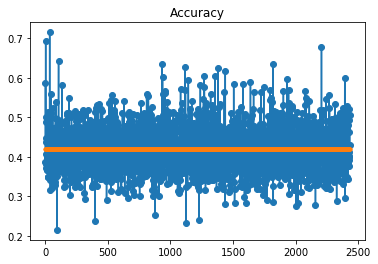

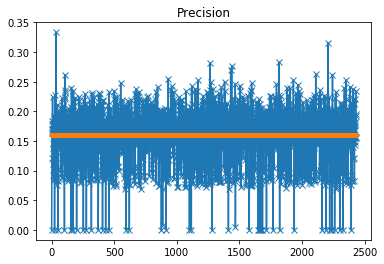

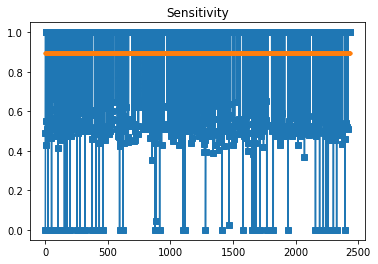

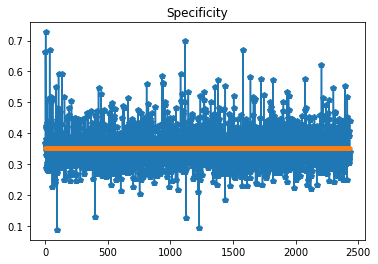

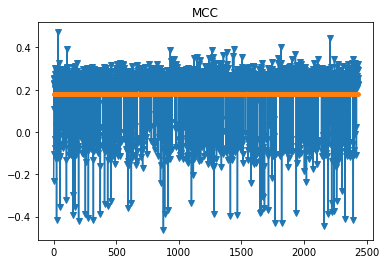

Average accuracy :  0.41978004371436906
Average precision :  0.15951398243289994
Average sensitivity :  0.8966385490116912
Average specificity :  0.35348645882161617
Average MCC :  0.17952171371094314


In [32]:
subopt2 = load_performances('subopt')

Loading the performances of duplex
[0.6443299  0.47160494 0.45501285 ... 0.50387597 0.56521739 0.45477387]
[0.         0.14084507 0.10798122 ... 0.18297872 0.21658986 0.19926199]


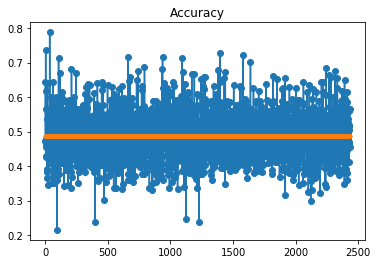

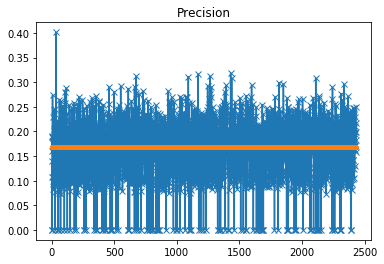

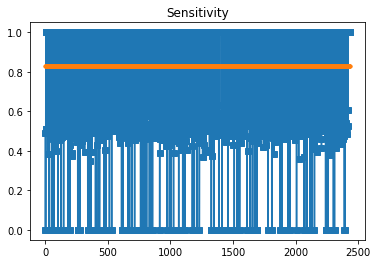

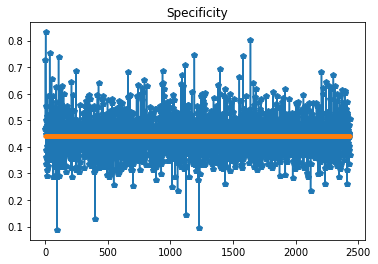

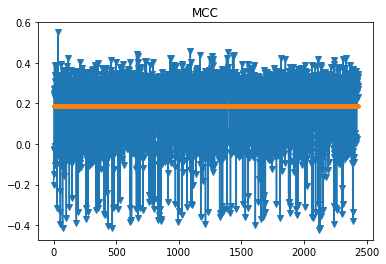

Average accuracy :  0.48785069140454757
Average precision :  0.16813295658465457
Average sensitivity :  0.8316423740418695
Average specificity :  0.4393241847072216
Average MCC :  0.18547072689567057


In [26]:
duplex = load_performances('duplex')

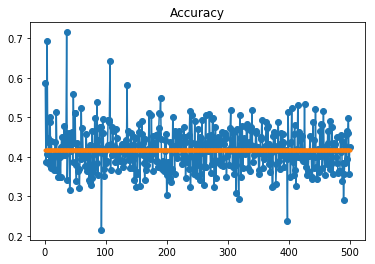

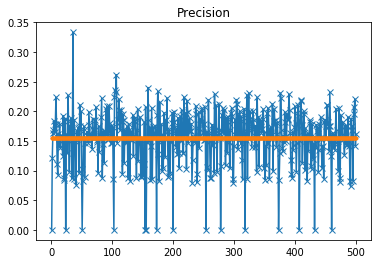

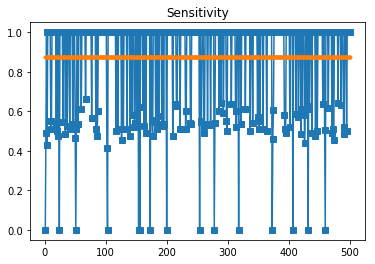

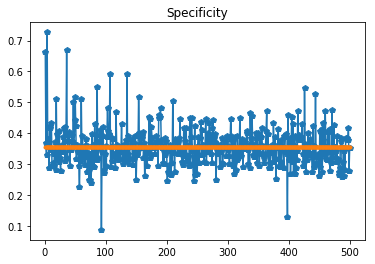

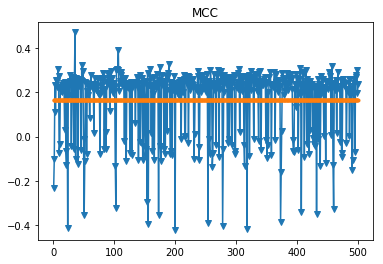

Average accuracy :  0.41818093696646813
Average precision :  0.1553791422972509
Average sensitivity :  0.8737604867808063
Average specificity :  0.3548488372093024
Average MCC :  0.165010186618138


In [27]:
plot_performances(subopt, 500)

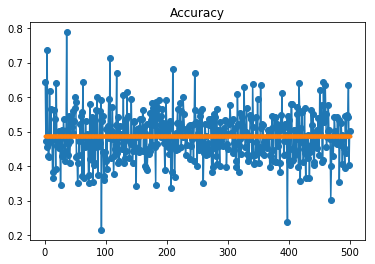

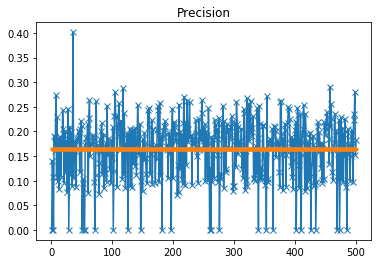

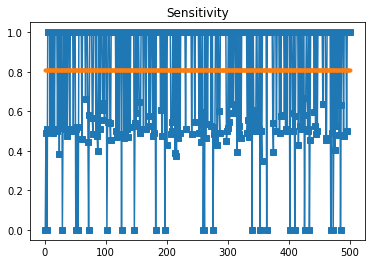

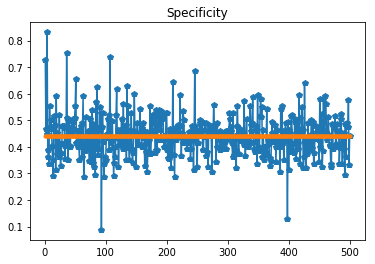

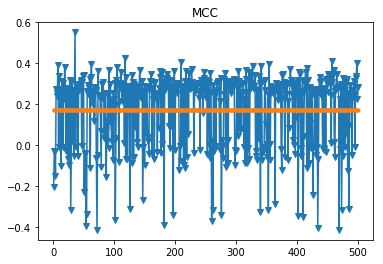

Average accuracy :  0.4860947793479295
Average precision :  0.16420907712235538
Average sensitivity :  0.8106984657087124
Average specificity :  0.44020348837209305
Average MCC :  0.17229296356994273


In [28]:
plot_performances(duplex, 500)

In [29]:
def plot_deeprna(): 
    mcc = np.load('benchmark_result/Deep_rna_rna_MCC.npy')
    length = len(mcc)    
    x = np.linspace(1,length,length)
    
    #Print the MCC and its average value
    fig1 = plt.figure(1)
    plt.clf()
    plt.title("MCC")
    p8 = plt.plot(x,mcc, label='MCC',marker='v')
    avg_mcc = np.mean(mcc)
    y = np.ones(length)
    y = np.dot(avg_mcc,y)
    p9 = plt.plot(x,y,marker='.')
    fig1.savefig('benchmark_result/'+'Deep_rna_rna'+'_MCC.png')
    plt.show()
    
    print("Average MCC : ", avg_mcc)

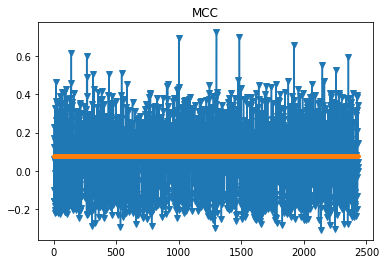

Average MCC :  0.08009286560875584


In [30]:
plot_deeprna()